# Step 1.Reading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive')


In [11]:
from multiple_targets import process_data_with_multiple_targets

# Example usage
data_path = '/content/drive/My Drive/eDO_data_M1.csv'
resampled_data = process_data_with_multiple_targets(data_path)
resampled_data.head()


/content/drive/My Drive/multiple_targets.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample('1H').agg({


,open,high,low,close,volume,Target_1,Target_2,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,close_lag_8,close_lag_9,close_lag_10,MA_3
TimeStamp,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,47143.98,47298.75,46715.39,46871.08,923.01760,C,C,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46811.77,46778.14,46656.13,47046.626667
2022-01-01 11:00:00,46871.09,47007.73,46756.77,46758.87,732.88793,C,C,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46811.77,46778.14,46924.643333
2022-01-01 12:00:00,46758.87,47150.48,46756.30,47074.05,582.15009,C,C,46758.87,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46811.77,46901.333333
2022-01-01 13:00:00,47074.05,47199.67,46935.09,47023.24,454.14412,C,C,47074.05,46758.87,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46952.053333
2022-01-01 14:00:00,47023.24,47100.00,46850.18,46926.22,503.66220,C,C,47023.24,47074.05,46758.87,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,47007.836667


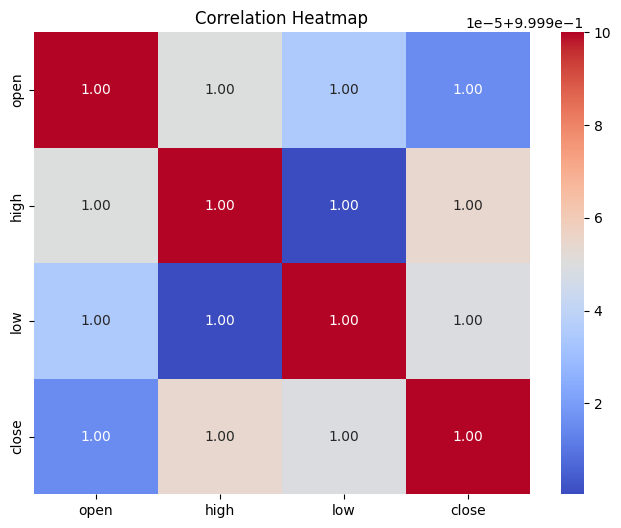

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = resampled_data[['open', 'high', 'low', 'close']].corr()

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#resampled_data = resampled_data.drop(columns=['Target_1'])

In [17]:
resampled_data.Target_2.unique()

array(['C', 'A', 'E'], dtype=object)

# Step 2: Model Selection and Training
Choose a machine learning model like  XGBoost,

## CNN

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming resampled_data is already resampled to H1 and has the Target_2 column
resampled_data.index = pd.to_datetime(resampled_data.index)  # Ensure datetime index

# Splitting the data
train_data = resampled_data[resampled_data.index < '2024-11-01']
test_data = resampled_data[resampled_data.index >= '2024-11-01']

# Normalize features (except the Target_2 column)
scaler = MinMaxScaler()
X_train = train_data.drop(columns=['Target_2']).values
X_test = test_data.drop(columns=['Target_2']).values

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode Target_2 labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['Target_2'])
y_test = encoder.transform(test_data['Target_2'])

# Reshape input features for CNN
time_steps = 10  # Number of time steps for sequence modeling

def create_sequences(data, labels, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# Reshape input for CNN (add channel dimension)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

# Build the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=120, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
cm = confusion_matrix(y_test_seq, y_pred_classes)
print(cm)

print("\nClassification Report:")
#report = classification_report(y_test_seq, y_pred_classes, Target_2_names=encoder.classes_)
#print(report)


Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7367 - loss: 0.7980 - val_accuracy: 0.7220 - val_loss: 0.7885
Epoch 2/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7405 - loss: 0.7536 - val_accuracy: 0.7220 - val_loss: 0.7857
Epoch 3/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7442 - loss: 0.7450 - val_accuracy: 0.7220 - val_loss: 0.8082
Epoch 4/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7426 - loss: 0.7471 - val_accuracy: 0.7220 - val_loss: 0.7856
Epoch 5/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7358 - loss: 0.7600 - val_accuracy: 0.7220 - val_loss: 0.7896
Epoch 6/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7422 - loss: 0.7490 - val_accuracy: 0.7220 - val_loss: 0.7896
Epoch 7/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7410 - loss: 0.7483 - val_accuracy: 0.7220 - val_loss: 0.7898
Epoch 8/120
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7402 - loss: 0.7498 - val_accuracy: 0.7220

In [20]:
# Evaluate on test data
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_test_seq, y_pred_classes, target_names=encoder.classes_))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Confusion Matrix:
[[  0  80   0]
 [  0 664   0]
 [  0 156   0]]

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        80
           C       0.74      1.00      0.85       664
           E       0.00      0.00      0.00       156

    accuracy                           0.74       900
   macro avg       0.25      0.33      0.28       900
weighted avg       0.54      0.74      0.63       900



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
df_counts_sorted = pd.DataFrame({
               'Train': train_data.Target_2.value_counts(),
               'Test': test_data.Target_2.value_counts()}).sort_index()                                             .sort_index()

df_counts_sorted

,Train,Test
Target_2,,
0,3032,83
1,18254,671
2,3470,156


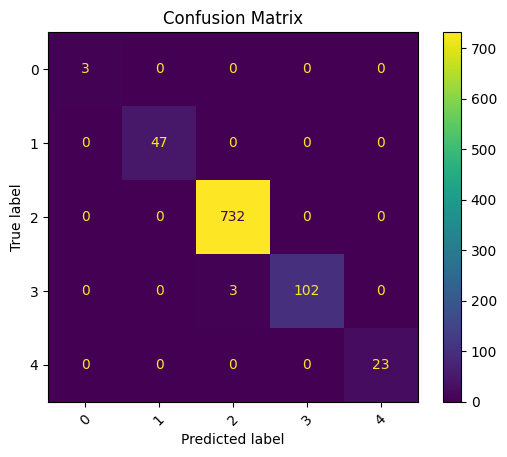

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round predictions to the nearest integer and ensure valid class indices
y_pred_rounded = np.round(y_pred).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()